# Postings Release Analysis: BGI vs Lightcast Comparison

In [7]:
# Snowflake connection setup
import snowflake.connector as snow
import pandas as pd
import os
import importlib.util
import matplotlib.pyplot as plt

# Load credentials from config file
config_file_path = r"C:\Users\JuliaNania\OneDrive - Burning Glass Institute\Documents\Python\config.py"
spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# Establish connection
conn = snow.connect(
    user=config.credentials['USERNAME'],
    password=config.credentials['PASSWORD'],
    account='PCA67849',
    warehouse=config.credentials['WAREHOUSE'],
    database='PROJECT_DATA'
)
print("Connected to Snowflake")

Connected to Snowflake


In [2]:
# Helper function to run queries
def run_query(query):
    return pd.read_sql(query, conn)

## 1. Monthly Posting Counts Comparison
Comparing monthly job posting volumes between BGI and Lightcast

In [ ]:
# Monthly posting counts: Lightcast US
lc_monthly_query = """
SELECT 
    DATE_TRUNC('month', POSTED) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) >= 2024 AND POSTED < '2025-04-01'
GROUP BY 1
ORDER BY 1
"""
lc_monthly = run_query(lc_monthly_query)
lc_monthly['SOURCE'] = 'Lightcast'

# Monthly posting counts: BGI US
bgi_monthly_query = """
SELECT 
    DATE_TRUNC('month', POST_DATE) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) >= 2024 AND POST_DATE < '2025-04-01'
GROUP BY 1
ORDER BY 1
"""
bgi_monthly = run_query(bgi_monthly_query)
bgi_monthly['SOURCE'] = 'BGI'

# Combine for comparison
monthly_comparison = lc_monthly.merge(bgi_monthly, on='MONTH', suffixes=('_LC', '_BGI'))
monthly_comparison['MONTH_NAME'] = pd.to_datetime(monthly_comparison['MONTH']).dt.strftime('%b %Y')

display(monthly_comparison[['MONTH_NAME', 'POSTING_COUNT_LC', 'POSTING_COUNT_BGI']].style.format({
    'POSTING_COUNT_LC': '{:,.0f}',
    'POSTING_COUNT_BGI': '{:,.0f}'
}))

In [ ]:
# Line chart: Monthly posting counts comparison
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(monthly_comparison['MONTH_NAME'], monthly_comparison['POSTING_COUNT_LC'] / 1e6, 
        marker='o', linewidth=2, label='Lightcast', color='#C22036')
ax.plot(monthly_comparison['MONTH_NAME'], monthly_comparison['POSTING_COUNT_BGI'] / 1e6, 
        marker='s', linewidth=2, label='BGI', color='#03497A')

ax.set_xlabel('Month', fontname='Verdana')
ax.set_ylabel('Posting Count (Millions)', fontname='Verdana')
ax.set_title('Monthly US Job Posting Counts: BGI vs Lightcast', fontname='Verdana')
ax.legend(loc='upper right')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

## 2. Salary Analysis
Comprehensive salary comparison between BGI and Lightcast

### 2.1 Salary Key Stats Comparison
Comparing min, max, average, and median salary_min between BGI and Lightcast

In [ ]:
# Salary stats: Lightcast (salary_from = salary_min)
lc_salary_query = """
SELECT 
    'Lightcast' AS SOURCE,
    MIN(SALARY_FROM) AS MIN_SALARY_MIN,
    MAX(SALARY_FROM) AS MAX_SALARY_MIN,
    AVG(SALARY_FROM) AS AVG_SALARY_MIN,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
"""
lc_salary = run_query(lc_salary_query)
display(lc_salary)

In [ ]:
# Salary stats: BGI (convert hourly to yearly if salary_per != 'year')
bgi_salary_query = """
SELECT 
    'BGI' AS SOURCE,
    MIN(YEARLY_SALARY_MIN) AS MIN_SALARY_MIN,
    MAX(YEARLY_SALARY_MIN) AS MAX_SALARY_MIN,
    AVG(YEARLY_SALARY_MIN) AS AVG_SALARY_MIN,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL 
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
)
"""
bgi_salary = run_query(bgi_salary_query)
display(bgi_salary)

In [ ]:
# Combined salary comparison table
salary_comparison = pd.concat([lc_salary, bgi_salary], ignore_index=True)
display(salary_comparison.style.format('{:,.2f}', subset=['MIN_SALARY_MIN', 'MAX_SALARY_MIN', 'AVG_SALARY_MIN', 'MEDIAN_SALARY_MIN']))

### 2.2 Salary Distribution
Distribution of minimum salary (annualized)

In [ ]:
# Query salary distribution in $10k buckets up to $200k + one ">200k" bucket
# Filtered to year 2025 only
lc_dist_query = """
SELECT 
    CASE 
        WHEN SALARY_FROM > 200000 THEN 210000
        ELSE FLOOR(SALARY_FROM / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
GROUP BY 1
ORDER BY 1
"""
lc_dist = run_query(lc_dist_query)

# Get total LC postings with salary for percentage calculation (2025 only)
lc_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
""")['TOTAL'].iloc[0]

bgi_dist_query = """
SELECT 
    CASE 
        WHEN YEARLY_SALARY_MIN > 200000 THEN 210000
        ELSE FLOOR(YEARLY_SALARY_MIN / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
)
GROUP BY 1
ORDER BY 1
"""
bgi_dist = run_query(bgi_dist_query)

# Get total BGI postings with salary for percentage calculation (2025 only)
bgi_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM (
    SELECT 1
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
)
""")['TOTAL'].iloc[0]

# Convert to percentages based on full 2025 dataset
lc_dist['PCT'] = lc_dist['COUNT'] / lc_total * 100
bgi_dist['PCT'] = bgi_dist['COUNT'] / bgi_total * 100

# Merge to align buckets for charting
salary_dist = lc_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'LC_PCT'}).merge(
    bgi_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'BGI_PCT'}),
    on='SALARY_BUCKET', how='outer'
).fillna(0).sort_values('SALARY_BUCKET')

print(f"LC total postings with salary (2025): {lc_total:,}")
print(f"BGI total postings with salary (2025): {bgi_total:,}")

In [ ]:
# Chart: Salary distribution with >200k bucket (2025 only)
fig, ax = plt.subplots(figsize=(14, 6))
x = salary_dist['SALARY_BUCKET']
width = 4000

ax.bar(x - width/2, salary_dist['LC_PCT'], width, label='Lightcast', color='#C22036')
ax.bar(x + width/2, salary_dist['BGI_PCT'], width, label='BGI', color='#03497A')
ax.set_xlabel('Salary Bucket ($)', fontname='Verdana')
ax.set_ylabel('% of Postings', fontname='Verdana')
ax.set_title('Distribution of Minimum Salary (2025)', fontname='Verdana')
ax.legend(loc='upper right')

# Custom formatter to show ">200k" for the 210000 bucket
def format_salary(x, _):
    if x == 210000:
        return '>$200k'
    return f'${x/1000:.0f}k'
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

### 2.3 Salary Outliers
Examples of very high and very low salary values

In [ ]:
# Examples of very high salary_min values with original SALARY_TEXT
high_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN DESC
LIMIT 20
"""
high_salary_examples = run_query(high_salary_query)
print("=== Very High Salary Examples ===")
display(high_salary_examples)

In [ ]:
# Examples of very low salary_min values with original SALARY_TEXT
low_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN ASC
LIMIT 20
"""
low_salary_examples = run_query(low_salary_query)
print("=== Very Low Salary Examples ===")
display(low_salary_examples)

### 2.4 Median Min Salary by SOC 2 Occupation
Comparing median minimum salary across broad occupation categories

In [ ]:
# Median min salary by SOC 2 occupation - Lightcast
lc_soc2_query = """
SELECT 
    SOC_2_NAME AS SOC2,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
  AND SOC_2_NAME IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2 = run_query(lc_soc2_query)
lc_soc2['SOURCE'] = 'Lightcast'

# Median min salary by SOC 2 occupation - BGI
bgi_soc2_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC2,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM (
    SELECT 
        p.ONET_CODE,
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
) sub
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.bgi_onet = sub.ONET_CODE
WHERE YEARLY_SALARY_MIN IS NOT NULL AND YEARLY_SALARY_MIN <= 500000
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_soc2 = run_query(bgi_soc2_query)
bgi_soc2['SOURCE'] = 'BGI'

# Merge for comparison
soc2_comparison = lc_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'LC_MEDIAN'}).merge(
    bgi_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'BGI_MEDIAN'}),
    on='SOC2', how='outer'
).fillna(0).sort_values('LC_MEDIAN', ascending=True)

display(soc2_comparison)

In [ ]:
# Horizontal bar chart: Median min salary by SOC 2 occupation
import numpy as np

# Filter out military and unclassified occupations
soc2_chart = soc2_comparison[~soc2_comparison['SOC2'].str.lower().str.contains('military|unclassified', na=False)]

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart))
height = 0.35

ax.barh(y - height/2, soc2_chart['LC_MEDIAN'], height, label='Lightcast', color='#C22036')
ax.barh(y + height/2, soc2_chart['BGI_MEDIAN'], height, label='BGI', color='#03497A')

ax.set_xlabel('Median Minimum Salary ($)', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Median Minimum Salary by SOC 2 Occupation (2025)', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart['SOC2'], fontname='Verdana', fontsize=10)
ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze similarity between LC and BGI median salaries by SOC 2
from scipy import stats

# Use filtered data (exclude military/unclassified and rows with 0 values)
soc2_valid = soc2_chart[(soc2_chart['LC_MEDIAN'] > 0) & (soc2_chart['BGI_MEDIAN'] > 0)].copy()

# Calculate difference metrics
soc2_valid['DIFF'] = soc2_valid['LC_MEDIAN'] - soc2_valid['BGI_MEDIAN']
soc2_valid['ABS_DIFF'] = soc2_valid['DIFF'].abs()
soc2_valid['PCT_DIFF'] = (soc2_valid['DIFF'] / soc2_valid['LC_MEDIAN']) * 100

# Correlation
correlation, p_value = stats.pearsonr(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])

# Summary statistics
print("=== Similarity Analysis: Median Min Salary by SOC 2 ===\n")
print(f"Number of SOC 2 categories compared: {len(soc2_valid)}")
print(f"\nCorrelation (Pearson r): {correlation:.3f} (p-value: {p_value:.4f})")
print(f"\nMean absolute difference: ${soc2_valid['ABS_DIFF'].mean():,.0f}")
print(f"Median absolute difference: ${soc2_valid['ABS_DIFF'].median():,.0f}")
print(f"\nMean % difference (LC vs BGI): {soc2_valid['PCT_DIFF'].mean():.1f}%")
print(f"Median % difference: {soc2_valid['PCT_DIFF'].median():.1f}%")

# Show detailed comparison
print("\n=== Detailed Comparison by SOC 2 ===")
display(soc2_valid.sort_values('ABS_DIFF', ascending=False)[['SOC2', 'LC_MEDIAN', 'BGI_MEDIAN', 'DIFF', 'PCT_DIFF']])

In [ ]:
# Scatter plot: LC vs BGI median salary by SOC 2
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'], color='#03497A', s=80, alpha=0.7)

# Add diagonal reference line (perfect agreement)
max_val = max(soc2_valid['LC_MEDIAN'].max(), soc2_valid['BGI_MEDIAN'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect agreement')

# Add regression line
slope, intercept, r, p, se = stats.linregress(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, color='#C22036', label=f'Regression (r={r:.2f})')

ax.set_xlabel('Lightcast Median Min Salary ($)', fontname='Verdana')
ax.set_ylabel('BGI Median Min Salary ($)', fontname='Verdana')
ax.set_title('LC vs BGI: Median Min Salary by SOC 2 (2025)', fontname='Verdana')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y/1000:.0f}k'))
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.5 Salary Coverage Analysis
What percentage of job postings have a minimum salary?

In [ ]:
# Salary coverage: % of postings with minimum salary (2025)

# Lightcast US coverage
lc_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) = 2025
"""
lc_us_coverage = run_query(lc_us_coverage_query)
lc_us_coverage['SOURCE'] = 'Lightcast'

# Lightcast UK coverage
lc_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.UK_POSTINGS
WHERE YEAR(POSTED) = 2025
"""
lc_uk_coverage = run_query(lc_uk_coverage_query)
lc_uk_coverage['SOURCE'] = 'Lightcast'

# BGI US coverage
bgi_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_us_coverage = run_query(bgi_us_coverage_query)
bgi_us_coverage['SOURCE'] = 'BGI'

# BGI UK coverage
bgi_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United Kingdom'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_uk_coverage = run_query(bgi_uk_coverage_query)
bgi_uk_coverage['SOURCE'] = 'BGI'

# Combine all
coverage_comparison = pd.concat([lc_us_coverage, lc_uk_coverage, bgi_us_coverage, bgi_uk_coverage], ignore_index=True)
coverage_comparison['PCT_WITH_SALARY'] = (coverage_comparison['POSTINGS_WITH_SALARY'] / coverage_comparison['TOTAL_POSTINGS']) * 100
coverage_comparison = coverage_comparison[['SOURCE', 'COUNTRY', 'TOTAL_POSTINGS', 'POSTINGS_WITH_SALARY', 'PCT_WITH_SALARY']]

print("=== Salary Coverage: Job Postings (2025) ===\n")
display(coverage_comparison.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_SALARY': '{:,.0f}',
    'PCT_WITH_SALARY': '{:.1f}%'
}))

# 3. Occupation Analysis

### 3.1 ONET Coverage
Comparing the number of postings with ONET classification between BGI and Lightcast

In [4]:
# ONET coverage: count postings where ONET is not null

# Lightcast: count postings with ONET_2019_NAME
lc_onet_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN ONET_2019_NAME IS NOT NULL THEN 1 ELSE 0 END) AS POSTINGS_WITH_ONET
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
"""
lc_onet = run_query(lc_onet_query)
lc_onet['SOURCE'] = 'Lightcast'

# BGI: count postings with TOP1_CODE from occupation classifier
bgi_onet_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN TOP1_CODE IS NOT NULL THEN 1 ELSE 0 END) AS POSTINGS_WITH_ONET
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL
"""
bgi_onet = run_query(bgi_onet_query)
bgi_onet['SOURCE'] = 'BGI'

# Combine and calculate percentages
onet_coverage = pd.concat([lc_onet, bgi_onet], ignore_index=True)
onet_coverage['PCT_WITH_ONET'] = (onet_coverage['POSTINGS_WITH_ONET'] / onet_coverage['TOTAL_POSTINGS']) * 100
onet_coverage = onet_coverage[['SOURCE', 'TOTAL_POSTINGS', 'POSTINGS_WITH_ONET', 'PCT_WITH_ONET']]

print("=== ONET Coverage: Postings with Occupation Classification ===\n")
display(onet_coverage.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_ONET': '{:,.0f}',
    'PCT_WITH_ONET': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_41720\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_41720\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== ONET Coverage: Postings with Occupation Classification ===



,SOURCE,TOTAL_POSTINGS,POSTINGS_WITH_ONET,PCT_WITH_ONET
0,Lightcast,"471,644,043","471,644,043",100.0%
1,BGI,"383,725,377","383,725,377",100.0%


### 3.2 Distribution by SOC 2 Occupation
Comparing posting distribution across broad occupation categories

In [ ]:
# Distribution by SOC 2 occupation

# Lightcast: distribution by SOC_2_NAME
lc_soc2_dist_query = """
SELECT 
    SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SOC_2_NAME IS NOT NULL and year(posted) = 2025
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2_dist = run_query(lc_soc2_dist_query)
lc_total_with_soc = lc_soc2_dist['POSTING_COUNT'].sum()
lc_soc2_dist['PCT'] = (lc_soc2_dist['POSTING_COUNT'] / lc_total_with_soc) * 100
lc_soc2_dist['SOURCE'] = 'Lightcast'

# BGI: join occupation classifier with lookup table to get SOC 2 names
bgi_soc2_dist_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.BGI_ONET = occ.TOP1_CODE
WHERE occ.TOP1_CODE IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_soc2_dist = run_query(bgi_soc2_dist_query)
bgi_total_with_soc = bgi_soc2_dist['POSTING_COUNT'].sum()
bgi_soc2_dist['PCT'] = (bgi_soc2_dist['POSTING_COUNT'] / bgi_total_with_soc) * 100
bgi_soc2_dist['SOURCE'] = 'BGI'

# Merge for side-by-side comparison
soc2_dist_comparison = lc_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
    columns={'POSTING_COUNT': 'LC_COUNT', 'PCT': 'LC_PCT'}
).merge(
    bgi_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_COUNT', 'PCT': 'BGI_PCT'}
    ),
    on='SOC_2_NAME', how='outer'
).fillna(0).sort_values('LC_PCT', ascending=False)

print(f"Lightcast total postings with SOC 2: {lc_total_with_soc:,.0f}")
print(f"BGI total postings with SOC 2: {bgi_total_with_soc:,.0f}\n")
display(soc2_dist_comparison.style.format({
    'LC_COUNT': '{:,.0f}',
    'BGI_COUNT': '{:,.0f}',
    'LC_PCT': '{:.1f}%',
    'BGI_PCT': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_41720\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_41720\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


Lightcast total postings with SOC 2: 471,644,043
BGI total postings with SOC 2: 383,725,377



,SOC_2_NAME,LC_COUNT,LC_PCT,BGI_COUNT,BGI_PCT
10,Healthcare Practitioners and Technical Occupations,"61,612,187",13.1%,"52,400,439",13.7%
22,Sales and Related Occupations,"50,574,290",10.7%,"30,306,585",7.9%
15,Management Occupations,"47,638,219",10.1%,"36,111,408",9.4%
18,Office and Administrative Support Occupations,"43,659,325",9.3%,"40,359,456",10.5%
5,Computer and Mathematical Occupations,"43,015,240",9.1%,"35,051,001",9.1%
3,Business and Financial Operations Occupations,"38,289,056",8.1%,"29,971,210",7.8%
23,Transportation and Material Moving Occupations,"29,553,540",6.3%,"19,940,594",5.2%
9,Food Preparation and Serving Related Occupations,"20,441,163",4.3%,"17,270,690",4.5%
12,"Installation, Maintenance, and Repair Occupations","17,529,934",3.7%,"15,808,362",4.1%
20,Production Occupations,"15,298,653",3.2%,"11,806,823",3.1%


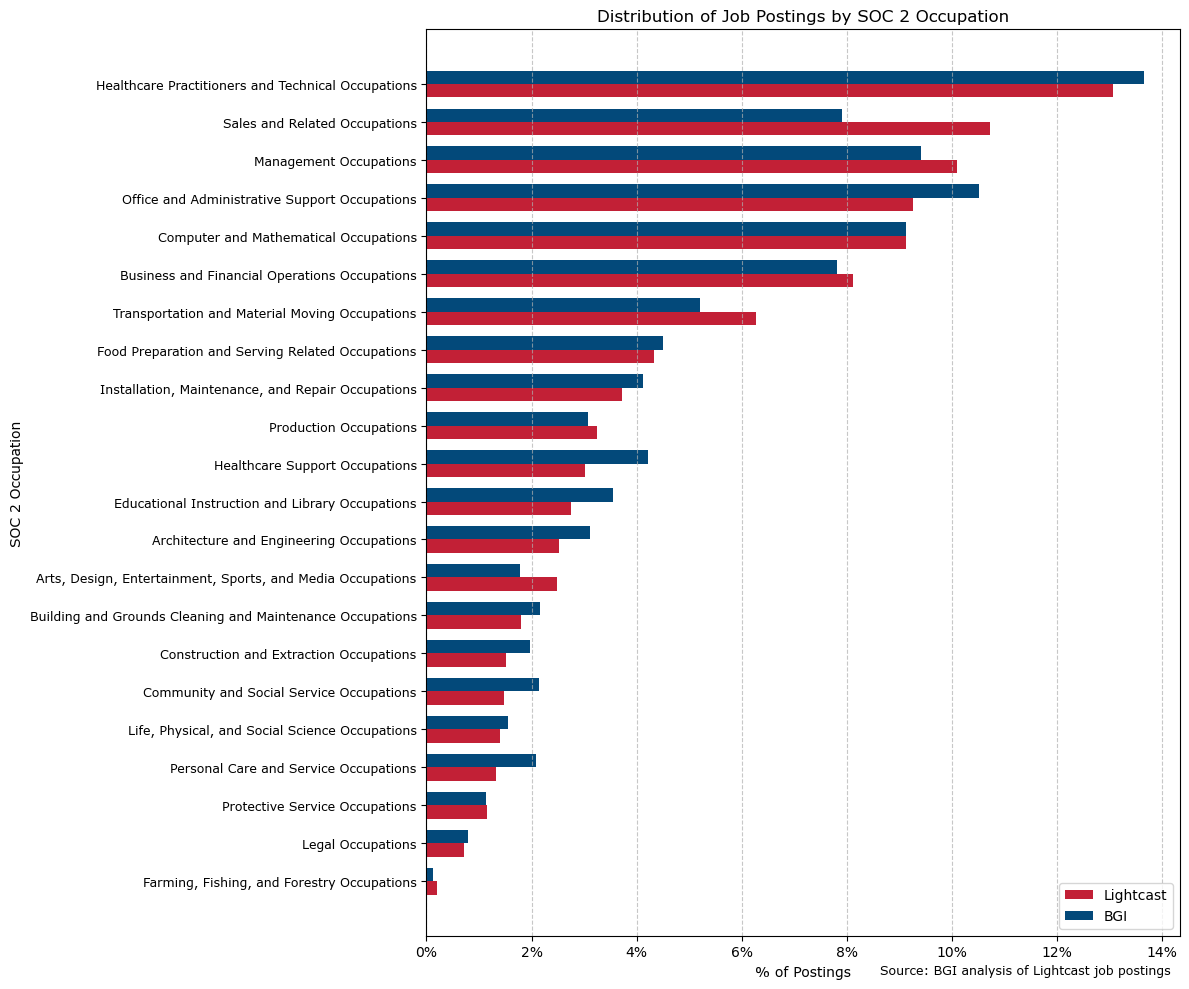

In [8]:
# Chart: SOC 2 distribution comparison (horizontal bar)
import numpy as np

# Filter out military/unclassified and sort by LC percentage
soc2_chart_data = soc2_dist_comparison[
    ~soc2_dist_comparison['SOC_2_NAME'].str.lower().str.contains('military|unclassified', na=False)
].sort_values('LC_PCT', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart_data))
height = 0.35

ax.barh(y - height/2, soc2_chart_data['LC_PCT'], height, label='Lightcast', color='#C22036')
ax.barh(y + height/2, soc2_chart_data['BGI_PCT'], height, label='BGI', color='#03497A')

ax.set_xlabel('% of Postings', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Distribution of Job Postings by SOC 2 Occupation', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart_data['SOC_2_NAME'], fontname='Verdana', fontsize=9)
ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()